In [1]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, roc_curve, f1_score, recall_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer 
from sklearn.ensemble import RandomForestClassifier


# Data Opening

In [118]:
train = pd.read_csv('train_auto.csv')
X_test_final = pd.read_csv('test_auto.csv')
train.head()

,INDEX,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,...,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
0,1,0,0.0,0,60.0,0,11.0,"$67,349",No,$0,...,"$14,230",11,Minivan,yes,"$4,461",2,No,3,18.0,Highly Urban/ Urban
1,2,0,0.0,0,43.0,0,11.0,"$91,449",No,"$257,252",...,"$14,940",1,Minivan,yes,$0,0,No,0,1.0,Highly Urban/ Urban
2,4,0,0.0,0,35.0,1,10.0,"$16,039",No,"$124,191",...,"$4,010",4,z_SUV,no,"$38,690",2,No,3,10.0,Highly Urban/ Urban
3,5,0,0.0,0,51.0,0,14.0,NaN,No,"$306,251",...,"$15,440",7,Minivan,yes,$0,0,No,0,6.0,Highly Urban/ Urban
4,6,0,0.0,0,50.0,0,NaN,"$114,986",No,"$243,925",...,"$18,000",1,z_SUV,no,"$19,217",2,Yes,3,17.0,Highly Urban/ Urban


In [3]:
train.describe()

,INDEX,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,TRAVTIME,TIF,CLM_FREQ,MVR_PTS,CAR_AGE
count,8161.000000,8161.000000,8161.000000,8161.000000,8155.000000,8161.000000,7707.000000,8161.000000,8161.000000,8161.000000,8161.000000,7651.000000
mean,5151.867663,0.263816,1504.324648,0.171057,44.790313,0.721235,10.499286,33.485725,5.351305,0.798554,1.695503,8.328323
std,2978.893962,0.440728,4704.026930,0.511534,8.627589,1.116323,4.092474,15.908333,4.146635,1.158453,2.147112,5.700742
min,1.000000,0.000000,0.000000,0.000000,16.000000,0.000000,0.000000,5.000000,1.000000,0.000000,0.000000,-3.000000
25%,2559.000000,0.000000,0.000000,0.000000,39.000000,0.000000,9.000000,22.000000,1.000000,0.000000,0.000000,1.000000
50%,5133.000000,0.000000,0.000000,0.000000,45.000000,0.000000,11.000000,33.000000,4.000000,0.000000,1.000000,8.000000
75%,7745.000000,1.000000,1036.000000,0.000000,51.000000,1.000000,13.000000,44.000000,7.000000,2.000000,3.000000,12.000000
max,10302.000000,1.000000,107586.136160,4.000000,81.000000,5.000000,23.000000,142.000000,25.000000,5.000000,13.000000,28.000000


In [4]:
train.isnull().sum()

INDEX            0
TARGET_FLAG      0
TARGET_AMT       0
KIDSDRIV         0
AGE              6
HOMEKIDS         0
YOJ            454
INCOME         445
PARENT1          0
HOME_VAL       464
MSTATUS          0
SEX              0
EDUCATION        0
JOB            526
TRAVTIME         0
CAR_USE          0
BLUEBOOK         0
TIF              0
CAR_TYPE         0
RED_CAR          0
OLDCLAIM         0
CLM_FREQ         0
REVOKED          0
MVR_PTS          0
CAR_AGE        510
URBANICITY       0
dtype: int64

Ok some values are missing, let's see what we'll do after exploring the dataset

In [5]:
train.dtypes

INDEX            int64
TARGET_FLAG      int64
TARGET_AMT     float64
KIDSDRIV         int64
AGE            float64
HOMEKIDS         int64
YOJ            float64
INCOME          object
PARENT1         object
HOME_VAL        object
MSTATUS         object
SEX             object
EDUCATION       object
JOB             object
TRAVTIME         int64
CAR_USE         object
BLUEBOOK        object
TIF              int64
CAR_TYPE        object
RED_CAR         object
OLDCLAIM        object
CLM_FREQ         int64
REVOKED         object
MVR_PTS          int64
CAR_AGE        float64
URBANICITY      object
dtype: object

Hmmm some features are considered as objects, we want them as int, let's handle that !

In [6]:
train['EDUCATION'].value_counts()

z_High School    2330
Bachelors        2242
Masters          1658
<High School     1203
PhD               728
Name: EDUCATION, dtype: int64

 z_High SCHOOl and <High School mean the same feature for us, let's correct it!

In [7]:
print("Per cent of 1 in the database :" ,np.sum(train['TARGET_FLAG'])/len(train['TARGET_FLAG']))

Per cent of 1 in the database : 0.2638157088592084


Data is quite unbalanced, only 1/4th of 1's on the database. Conceivably one's want to predict if the client will claim or not. Accuracy may not be the only relevant metrics in this case, one may glance at the confusion matrix. In order to hedge our global position, it coulb be interesting to focus on avoiding false negatives (it costs money that was not planned). Recall must then be taken into account later. F1 score may be a great trade-off

# Data Cleaning

In [8]:
y = train['TARGET_FLAG'].copy()

In [9]:
X_train = train.copy().drop(['TARGET_FLAG','TARGET_AMT','INDEX'], axis = 1) 


In [10]:
X_train

,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,EDUCATION,...,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
0,0,60.0,0,11.0,"$67,349",No,$0,z_No,M,PhD,...,"$14,230",11,Minivan,yes,"$4,461",2,No,3,18.0,Highly Urban/ Urban
1,0,43.0,0,11.0,"$91,449",No,"$257,252",z_No,M,z_High School,...,"$14,940",1,Minivan,yes,$0,0,No,0,1.0,Highly Urban/ Urban
2,0,35.0,1,10.0,"$16,039",No,"$124,191",Yes,z_F,z_High School,...,"$4,010",4,z_SUV,no,"$38,690",2,No,3,10.0,Highly Urban/ Urban
3,0,51.0,0,14.0,NaN,No,"$306,251",Yes,M,<High School,...,"$15,440",7,Minivan,yes,$0,0,No,0,6.0,Highly Urban/ Urban
4,0,50.0,0,NaN,"$114,986",No,"$243,925",Yes,z_F,PhD,...,"$18,000",1,z_SUV,no,"$19,217",2,Yes,3,17.0,Highly Urban/ Urban
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8156,0,35.0,0,11.0,"$43,112",No,$0,z_No,M,z_High School,...,"$27,330",10,Panel Truck,yes,$0,0,No,0,8.0,z_Highly Rural/ Rural
8157,1,45.0,2,9.0,"$164,669",No,"$386,273",Yes,M,PhD,...,"$13,270",15,Minivan,no,$0,0,No,2,17.0,Highly Urban/ Urban
8158,0,46.0,0,9.0,"$107,204",No,"$332,591",Yes,M,Masters,...,"$24,490",6,Panel Truck,no,$0,0,No,0,1.0,Highly Urban/ Urban
8159,0,50.0,0,7.0,"$43,445",No,"$149,248",Yes,z_F,Bachelors,...,"$22,550",6,Minivan,no,$0,0,No,0,11.0,Highly Urban/ Urban


In [11]:
X_train.columns

Index(['KIDSDRIV', 'AGE', 'HOMEKIDS', 'YOJ', 'INCOME', 'PARENT1', 'HOME_VAL',
       'MSTATUS', 'SEX', 'EDUCATION', 'JOB', 'TRAVTIME', 'CAR_USE', 'BLUEBOOK',
       'TIF', 'CAR_TYPE', 'RED_CAR', 'OLDCLAIM', 'CLM_FREQ', 'REVOKED',
       'MVR_PTS', 'CAR_AGE', 'URBANICITY'],
      dtype='object')

In [12]:
# INCOME & HOME_VAL have missing values + we want to transform them in float
X_train['INCOME'] = X_train['INCOME'].str.replace('[$,<,z_]', '').replace('None', np.nan).astype(float)
X_train['HOME_VAL'] = X_train['HOME_VAL'].str.replace('[$,<,z_]', '').replace('None', np.nan).astype(float)
X_train['MSTATUS'] = X_train['MSTATUS'].str.replace('[$,<,z_]', '') 
X_train['SEX'] = X_train['SEX'].str.replace('[$,<,z_]', '') 
X_train['EDUCATION'] = X_train['EDUCATION'].str.replace('[$,<,z_]', '') 
X_train['CAR_TYPE'] = X_train['CAR_TYPE'].str.replace('[$,<,z_]', '') 
X_train['BLUEBOOK'] = X_train['BLUEBOOK'].str.replace('[$,<,z_]', '').replace('None', np.nan).astype(float)
X_train['OLDCLAIM'] = X_train['OLDCLAIM'].str.replace('[$,<,z_]', '').astype(float)
X_train['URBANICITY'] = X_train['URBANICITY'].str.replace('[$,<,z_]', '') 

In [13]:
# A class to select numerical or categorical columns 
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [14]:
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

Let's create a pipeline to make things easier

In [15]:
num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(["KIDSDRIV","AGE","HOMEKIDS","YOJ", "INCOME", "HOME_VAL","TRAVTIME","BLUEBOOK","TIF","OLDCLAIM","CLM_FREQ","MVR_PTS","CAR_AGE"])),
        ("imputer", SimpleImputer(strategy="median")),
        ('std_scaler', MinMaxScaler()),
    ])

cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(["MSTATUS","SEX","EDUCATION","JOB","CAR_USE","CAR_TYPE", "RED_CAR", "PARENT1","REVOKED","URBANICITY"])),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [16]:
X_train = preprocess_pipeline.fit_transform(X_train)
X_train


array([[0.        , 0.67692308, 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.41538462, 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.29230769, 0.2       , ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.        , 0.46153846, 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.52307692, 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.55384615, 0.        , ..., 0.        , 1.        ,
        0.        ]])

In [17]:
X_train , X_test , Y_train , Y_test = train_test_split(X_train , y , random_state = 666)

# First Method: SVM

In [18]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="scale")
svm_clf.fit(X_train, Y_train)

SVC()

In [19]:
y_pred = svm_clf.predict(X_test)
svm_scores = cross_val_score(svm_clf, X_train, Y_train,cv=10)
svm_scores.mean()

0.7838235294117647

In [20]:
print("Accuracy on the test set:", svm_clf.score(X_test, Y_test))

cm = confusion_matrix(Y_test, y_pred)
print("Confusion matrix on the test set:", cm)

Accuracy on the test set: 0.7609015188633023
Confusion matrix on the test set: [[1365  115]
 [ 373  188]]


# Lasso Logistic Regression

In [21]:
linreg = LogisticRegression(penalty='none')
linreg.fit(X_train, Y_train)
print("Accuracy on the test set:", linreg.score(X_test, Y_test))

cm = confusion_matrix(Y_test, linreg.predict(X_test))
print("Confusion matrix on the test set:", cm)

Accuracy on the test set: 0.7814796668299853
Confusion matrix on the test set: [[1357  123]
 [ 323  238]]


In [22]:
linreg2 = LogisticRegression(penalty='l1', C=1, solver='liblinear', max_iter=5000)
linreg2.fit(X_train, Y_train)
print("Accuracy on the test set:", linreg2.score(X_test, Y_test))

cm = confusion_matrix(Y_test, linreg2.predict(X_test))
print("Confusion matrix on the test set:", cm)

Accuracy on the test set: 0.7834394904458599
Confusion matrix on the test set: [[1361  119]
 [ 323  238]]


In [54]:
# likely to overfit

# Cross-validation


In [23]:
grid = {'C': [1/100 * (10 ** i) for i in range(10)]}

In [24]:
LassoCV = GridSearchCV(LogisticRegression(), grid)
LassoCV.fit(X_train, Y_train)
print("Accuracy on the test set:", LassoCV.score(X_test, Y_test))

cm = confusion_matrix(Y_test, LassoCV.predict(X_test))
print("Confusion matrix on the test set:", cm)

C:\Users\andre\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

Accuracy on the test set: 0.781969622733954
Confusion matrix on the test set: [[1359  121]
 [ 324  237]]


In [25]:
print("Best hyperparameter:", LassoCV.best_params_)

Best hyperparameter: {'C': 1.0}


# Random Forest


In [26]:
forest_clf = RandomForestClassifier(n_estimators=150, random_state=666)
forest_scores = cross_val_score(forest_clf, X_train, Y_train, cv=10)
forest_scores.mean()

0.7947712418300654

In [27]:
param_grid = {
                 'n_estimators': [116, 117,115,114],
                 'max_depth': [25, 24,26]
             }
ForestCV = GridSearchCV(forest_clf, param_grid, cv=10)
ForestCV.fit(X_train, Y_train)

GridSearchCV(cv=10,
             estimator=RandomForestClassifier(n_estimators=150,
                                              random_state=666),
             param_grid={'max_depth': [25, 24, 26],
                         'n_estimators': [116, 117, 115, 114]})

In [28]:
ForestCV.best_params_

{'max_depth': 25, 'n_estimators': 115}

In [29]:
print("Accuracy on the test set:", ForestCV.score(X_test, Y_test))

cm = confusion_matrix(Y_test, ForestCV.predict(X_test))
print("Confusion matrix on the test set:", cm)

Accuracy on the test set: 0.7814796668299853
Confusion matrix on the test set: [[1370  110]
 [ 336  225]]


# ROC Curve

Text(0.5, 1.0, 'ROC curve')

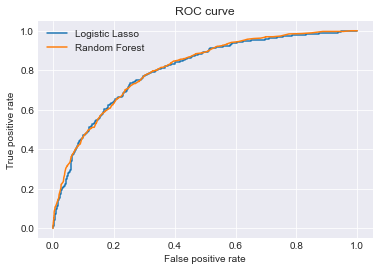

In [30]:
# Matplotlib style
plt.style.use("seaborn-darkgrid")
fpr_lasso, tpr_lasso, _ = roc_curve(Y_test, LassoCV.predict_proba(X_test)[:,1])
fpr_forest, tpr_forest, _ = roc_curve(Y_test, ForestCV.predict_proba(X_test)[:,1])
plt.plot(fpr_lasso, tpr_lasso, label='Logistic Lasso')
plt.plot(fpr_forest, tpr_forest, label='Random Forest')
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve")

# Submitting the results

In [31]:
X_train_final = train.copy().drop(['TARGET_FLAG','TARGET_AMT','INDEX'], axis = 1) 
Y_train_final = train['TARGET_FLAG'].copy()

In [32]:
X_train_final['INCOME'] = X_train_final['INCOME'].str.replace('[$,<,z_]', '').replace('None', np.nan).astype(float)
X_train_final['HOME_VAL'] = X_train_final['HOME_VAL'].str.replace('[$,<,z_]', '').replace('None', np.nan).astype(float)
X_train_final['MSTATUS'] = X_train_final['MSTATUS'].str.replace('[$,<,z_]', '') 
X_train_final['SEX'] = X_train_final['SEX'].str.replace('[$,<,z_]', '') 
X_train_final['EDUCATION'] = X_train_final['EDUCATION'].str.replace('[$,<,z_]', '') 
X_train_final['CAR_TYPE'] = X_train_final['CAR_TYPE'].str.replace('[$,<,z_]', '') 
X_train_final['BLUEBOOK'] = X_train_final['BLUEBOOK'].str.replace('[$,<,z_]', '').replace('None', np.nan).astype(float)
X_train_final['OLDCLAIM'] = X_train_final['OLDCLAIM'].str.replace('[$,<,z_]', '').astype(float)
X_train_final['URBANICITY'] = X_train_final['URBANICITY'].str.replace('[$,<,z_]', '') 

X_test_final['INCOME'] = X_test_final['INCOME'].str.replace('[$,<,z_]', '').replace('None', np.nan).astype(float)
X_test_final['HOME_VAL'] = X_test_final['HOME_VAL'].str.replace('[$,<,z_]', '').replace('None', np.nan).astype(float)
X_test_final['MSTATUS'] = X_test_final['MSTATUS'].str.replace('[$,<,z_]', '') 
X_test_final['SEX'] = X_test_final['SEX'].str.replace('[$,<,z_]', '') 
X_test_final['EDUCATION'] = X_test_final['EDUCATION'].str.replace('[$,<,z_]', '') 
X_test_final['CAR_TYPE'] = X_test_final['CAR_TYPE'].str.replace('[$,<,z_]', '') 
X_test_final['BLUEBOOK'] = X_test_final['BLUEBOOK'].str.replace('[$,<,z_]', '').replace('None', np.nan).astype(float)
X_test_final['OLDCLAIM'] = X_test_final['OLDCLAIM'].str.replace('[$,<,z_]', '').astype(float)
X_test_final['URBANICITY'] = X_test_final['URBANICITY'].str.replace('[$,<,z_]', '') 

In [33]:

X_test_final = X_test_final.drop(['TARGET_FLAG','TARGET_AMT','INDEX'], axis = 1) 

In [34]:
X_test_final = preprocess_pipeline.fit_transform(X_test_final)
X_train_final = preprocess_pipeline.fit_transform(X_train_final)

In [54]:
ForestCV.fit(X_train_final, Y_train_final)
LassoCV.fit(X_train_final, Y_train_final)

C:\Users\andre\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0,
                               100000.0, 1000000.0, 10000000.0]})

In [42]:
forest_clf_final = RandomForestClassifier(n_estimators=115, max_depth=25, random_state=666)
forest_scores = cross_val_score(forest_clf_final, X_train_final, Y_train_final, cv=10)
forest_scores.mean()

0.7929196066431469

In [50]:
param_grid = {
                 'n_estimators': [120, 117],
                 'max_depth': [26,27]
             }
ForestFinal = GridSearchCV(forest_clf_final, param_grid, cv=10)
ForestFinal.fit(X_train_final, Y_train_final)

GridSearchCV(cv=10,
             estimator=RandomForestClassifier(max_depth=25, n_estimators=115,
                                              random_state=666),
             param_grid={'max_depth': [26, 27], 'n_estimators': [120, 117]})

In [51]:
ForestFinal.best_params_

{'max_depth': 26, 'n_estimators': 117}

In [113]:
submit1 = ForestFinal.predict(X_test_final)
submit2 = LassoCV.predict(X_test_final)


In [120]:
my_submission1 = pd.DataFrame({'INDEX': X_test_final.INDEX, 'TARGET_FLAG': submit1})
my_submission2 = pd.DataFrame({'INDEX': X_test_final.INDEX, 'TARGET_FLAG': submit2})

In [125]:
my_submission1.to_csv('RandomForestsubmission.csv', index=False)
my_submission2.to_csv('LassoCVsubmission.csv', index=False)